In [6]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

def grille_Riemann(dim, taille_echantillon):
    """
    Retourne les centres d'hypercubes d'une grille multidimensionnelle
    """
    N = int(taille_echantillon**(1/dim)) # nb de boites par cote, eventuellement arrondi
    delta=2/N
    allG = [np.linspace(-1+delta/2,1-delta/2,num=N) for G in range(dim)]
    mesh = np.meshgrid(*allG)
    ans = list(zip(*(d.flat for d in mesh)))
    if len(ans) != taille_echantillon:
        print("  - Taille d'echantillon ajustee pour la methode de Riemann:"
              ,len(ans),"au lieu de",taille_echantillon,"(dimension =",dim,")")
    return np.array(ans)

def N_effectif(dim, taille_echantillon):
    """
    Retourne le nombre d'hypercubes utilisés lors de la discrétisation
    donne le même résultat que len(grille_Riemann(dim, taille_echantillon))
    mais sans générer la grille
    """
    return (int(taille_echantillon**(1/dim)))**dim

<div class="alert alert-danger"><b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>

<a id="RIEMANN"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> I. Calcul du volume d'une sphère par la méthode de Riemann</h1>

<div class="alert alert-success">On montre dans cette partie les limitations des techniques d'intégration en grande dimension. L'exemple de l'estimation du volume d'une sphère sera le fil rouge du cours.</div>

Le volume $V_d$ délimité par la sphère de rayon $1$ en dimension $d$ est donné par l'expression suivante:

$$ V_d = \frac{\pi^{d/2}}{\Gamma(d/2+1)} \mathop{\sim}_{d \to \infty} \frac{1}{\sqrt{\pi d}} \left( \frac{2e\pi}{d} \right)^{d/2}
$$

où $\Gamma$ correspond à la fonction Gamma. En réexprimant $V_d$ sous forme intégrale,
$$ V_d = \int_{[-1,1]^d} f(x) dx \ \text{ avec } \ f(x) = {\bf 1}(\lVert x \rVert \leq 1) $$
on souhaite retrouver la valeur de $V_d$ en estimant l'intégrale ci-dessus à l'aide de sommes de Riemann. Si l'on divise $[-1,1]^d$ en hypercubes de côté $\delta$, on obtient alors l'approximation
$$ \int_{[-1,1]^d} f \approx \widehat V^{\text{R}}_d \ \text{ avec } \ \widehat V^{\text{R}}_d = \sum_{k=1}^N \delta^d f(x_k) = \frac{2^d}{N} \sum_{k=1}^N f(x_k) $$
où les $x_k$ sont les centres des hypercubes et $N  = (2/\delta)^d$ est le nombre d'hypercubes. Puisque $f$ est continue par morceaux, on a bien $\widehat V^{\text{R}}_d \to V_d$ lorsque le nombre $N$ d'hypercubes utilisés tend vers $+\infty$, *i.e.* lorsque le pas $\delta$ de la discrétisation tend vers $0$.

<div class="alert alert-success">On définit l'<b>écart relatif</b> comme la différence entre l'estimateur et sa valeur théorique, normalisée par la valeur théorique,
$$ \text{écart relatif} = \frac{ \widehat V - V }{V} $$
Ici, on connaît la valeur théorique et on peut donc calculer cet écart relatif, mais en pratique la valeur théorique, et donc l'écart relatif, est inconnue.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION I.1.</b> Complétez la fonction <code>estimation_Riemann</code> ci-dessous, puis utilisez le script suivant pour tracer sur une même courbe $\widehat V^{\text{R}}_d$ et sa valeur théorique lorsque $d$ varie entre $2$ et $13$, puis tracez l'évolution de l'écart relatif. Commentez les résultats obtenus et notamment l'influence de $N$ et de la dimension $d$. Expliquez en particulier le comportement de l'erreur lorsque la dimension grandit.</p>

In [7]:
def estimation_Riemann(dim, grille):
    """
    Calcule l'approximation du volume de la sphère en dimension
    dim à l'aide de sommes de Riemann sur la grille fournie
    """
    N = len(grille) # la grille sont les valeurs x_k
    # function f
    estimation = 2**dim/N*sum(np.linalg.norm(grille,axis = 1)<=1)
    V = np.pi**(dim/2)/special.gamma(dim/2+1)
    #V = 1/np.sqrt(np.pi*dim)*(2*np.e*np.pi/dim)**(dim/2)
    ecart_relatif = (estimation-V)/V
    #print([estimation, ecart_relatif])
    return [estimation, ecart_relatif]
#print(estimation_Riemann(2, grille_Riemann(2, 100000)))

Estimation par la méthode de Riemann en dimension 2
Estimation par la méthode de Riemann en dimension 3
  - Taille d'echantillon ajustee pour la methode de Riemann: 970299 au lieu de 1000000 (dimension = 3 )
Estimation par la méthode de Riemann en dimension 4
  - Taille d'echantillon ajustee pour la methode de Riemann: 923521 au lieu de 1000000 (dimension = 4 )
Estimation par la méthode de Riemann en dimension 5
  - Taille d'echantillon ajustee pour la methode de Riemann: 759375 au lieu de 1000000 (dimension = 5 )
Estimation par la méthode de Riemann en dimension 6
  - Taille d'echantillon ajustee pour la methode de Riemann: 531441 au lieu de 1000000 (dimension = 6 )
Estimation par la méthode de Riemann en dimension 7
  - Taille d'echantillon ajustee pour la methode de Riemann: 823543 au lieu de 1000000 (dimension = 7 )
Estimation par la méthode de Riemann en dimension 8
  - Taille d'echantillon ajustee pour la methode de Riemann: 390625 au lieu de 1000000 (dimension = 8 )
Estimation p

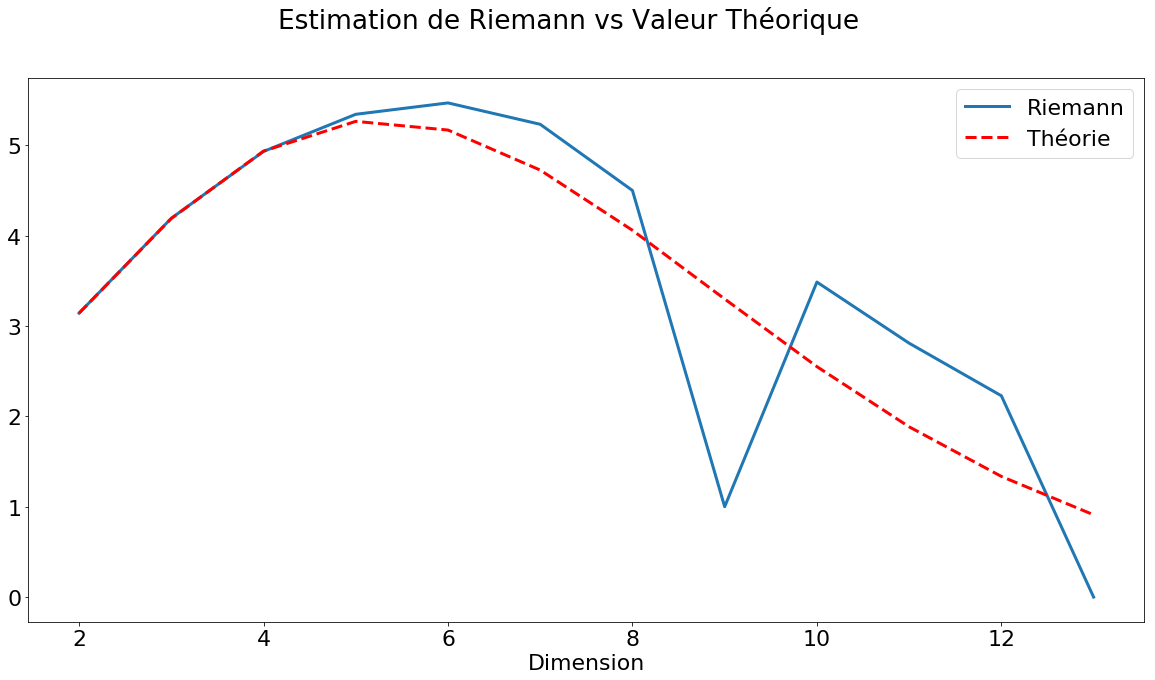

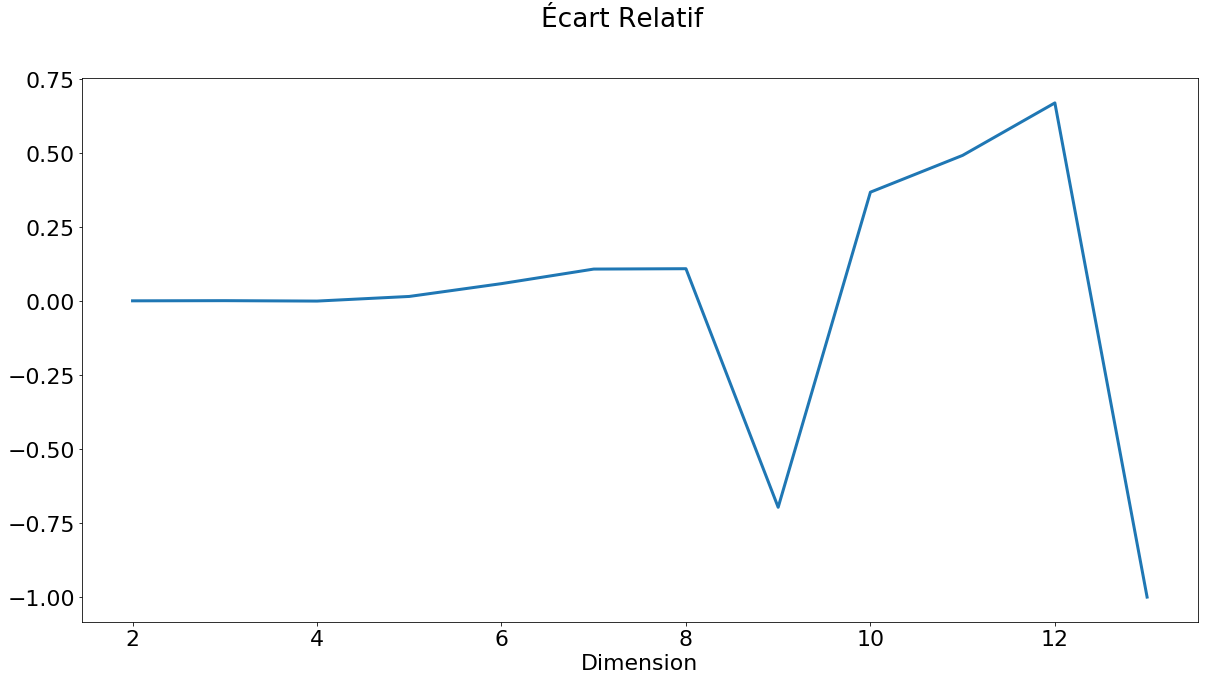

In [8]:
# Paramètres
N = 10**6 # taille echantillon
dimensions = range(2,14) # variable d
nb_dimensions = len(dimensions)

# Calculs des valeurs
est_Riemann = np.zeros([nb_dimensions,2])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par la méthode de Riemann en dimension",dim)
    val_th[i] = np.pi**(dim/2)/special.gamma(dim/2+1)
    est_Riemann[i,:] = estimation_Riemann(dim, grille_Riemann(dim, N))

# Affichage
fig =plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Estimation de Riemann vs Valeur Théorique")
plt.xlabel("Dimension")
plt.show()

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1])
fig.suptitle("Écart Relatif")
plt.xlabel("Dimension")
plt.show()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.1.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION I.2.</b> Que calcule le code suivant ? Commentez la courbe obtenue.</p>

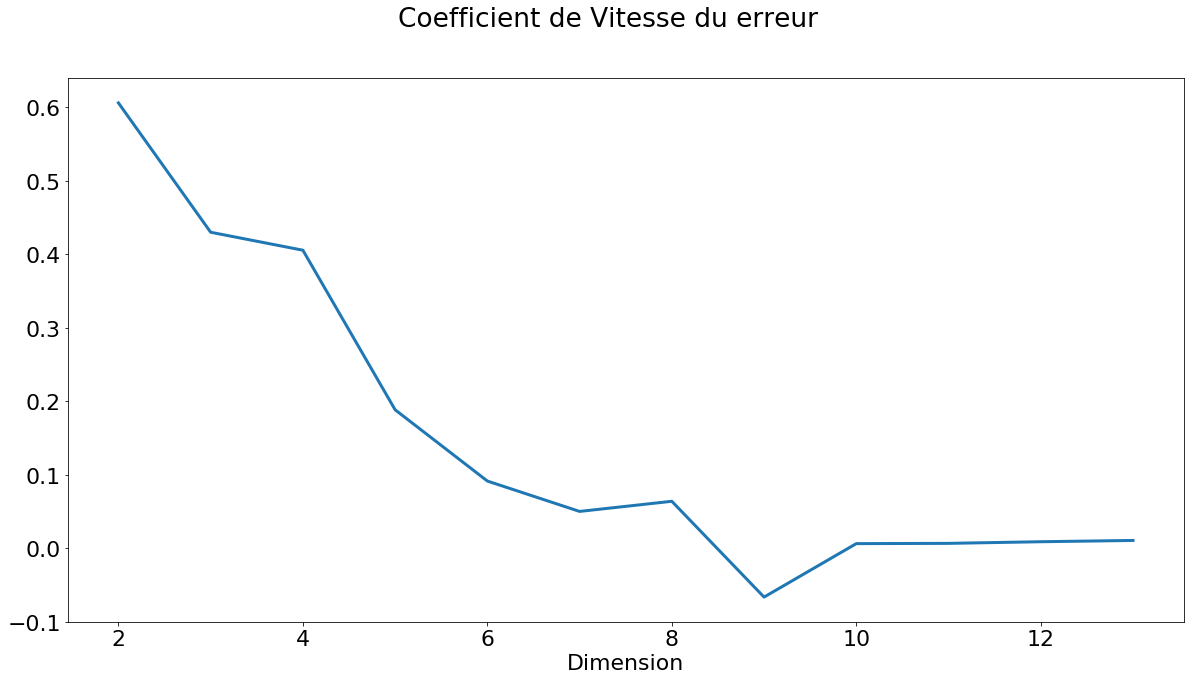

In [9]:
vitesse_R = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_R[i] = -np.log(np.abs(est_Riemann[i,0] - val_th[i])) / np.log(N_effectif(dim, N))
plt.plot(dimensions, vitesse_R)
plt.suptitle("Coefficient de Vitesse du erreur")
plt.xlabel("Dimension")
plt.show()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.2.</b> Calcul du coefficient \alpha qui donne la vitesse de changement de l'erreur en fonction de la dimension des hypercubes. Donc, il montre la sensibilité qu nivequ d'erreur en fonction de la dimension. </div>

On s'intéresse à la robustesse de l'estimation précédente. Pour cela, on considère
$$ \widehat V^{\text{Rc}}_d = \frac{2^d}{N} \sum_{k=1}^N f(c_k) $$
où $c_k$ est le coin de l'hypercube $k$, i.e., $c_k = x_k + \frac{\delta}{2} {\bf 1}$ avec ${\bf 1} = (1, \ldots, 1) \in R^n$.

<p class="bg-primary" style="padding:1em"><b>QUESTION I.3.</b> Définissez la fonction <code>estimation_Riemann_coin</code> afin qu'elle renvoie l'estimation et l'écart correspondant à cette nouvelle approximation. Rajoutez sur les courbes précédentes les résultats liés à cette estimation et commentez les résultats obtenus.</p>

In [10]:
def estimation_Riemann_coin(dim, grille):
    N = len(grille)
    delta = 2/N**(1/dim)
    estimation = 2**dim/N*sum(np.linalg.norm(grille+delta/2*np.ones(dim),axis = 1)<=1)
    V = np.pi**(dim/2)/special.gamma(dim/2+1)
    ecart_relatif = (estimation-V)/V
    #print([estimation, ecart_relatif])
    return [estimation, ecart_relatif]

In [11]:
a = np.matrix([[1,1],[3,2]])
print(a)
a + np.ones(2)

[[1 1]
 [3 2]]


matrix([[ 2.,  2.],
        [ 4.,  3.]])

Estimation par la méthode de Riemann en dimension 2
Estimation par la méthode de Riemann en dimension 3
  - Taille d'echantillon ajustee pour la methode de Riemann: 970299 au lieu de 1000000 (dimension = 3 )
Estimation par la méthode de Riemann en dimension 4
  - Taille d'echantillon ajustee pour la methode de Riemann: 923521 au lieu de 1000000 (dimension = 4 )
Estimation par la méthode de Riemann en dimension 5
  - Taille d'echantillon ajustee pour la methode de Riemann: 759375 au lieu de 1000000 (dimension = 5 )
Estimation par la méthode de Riemann en dimension 6
  - Taille d'echantillon ajustee pour la methode de Riemann: 531441 au lieu de 1000000 (dimension = 6 )
Estimation par la méthode de Riemann en dimension 7
  - Taille d'echantillon ajustee pour la methode de Riemann: 823543 au lieu de 1000000 (dimension = 7 )
Estimation par la méthode de Riemann en dimension 8
  - Taille d'echantillon ajustee pour la methode de Riemann: 390625 au lieu de 1000000 (dimension = 8 )
Estimation p

Text(0.5,0,'Dimension')

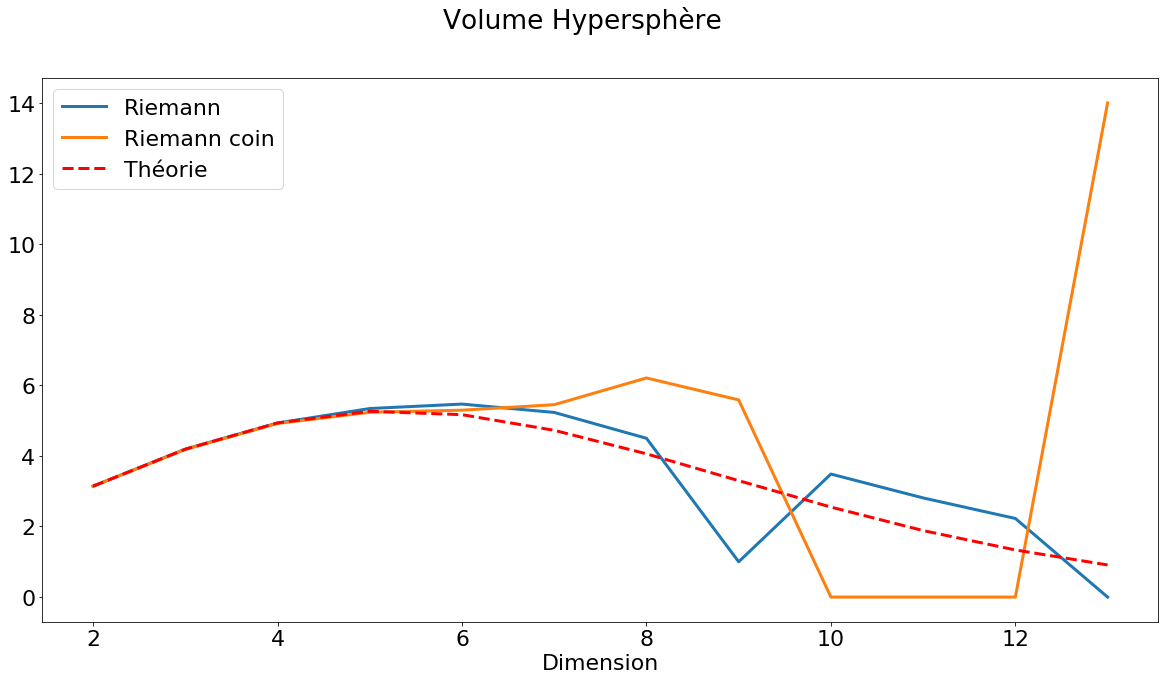

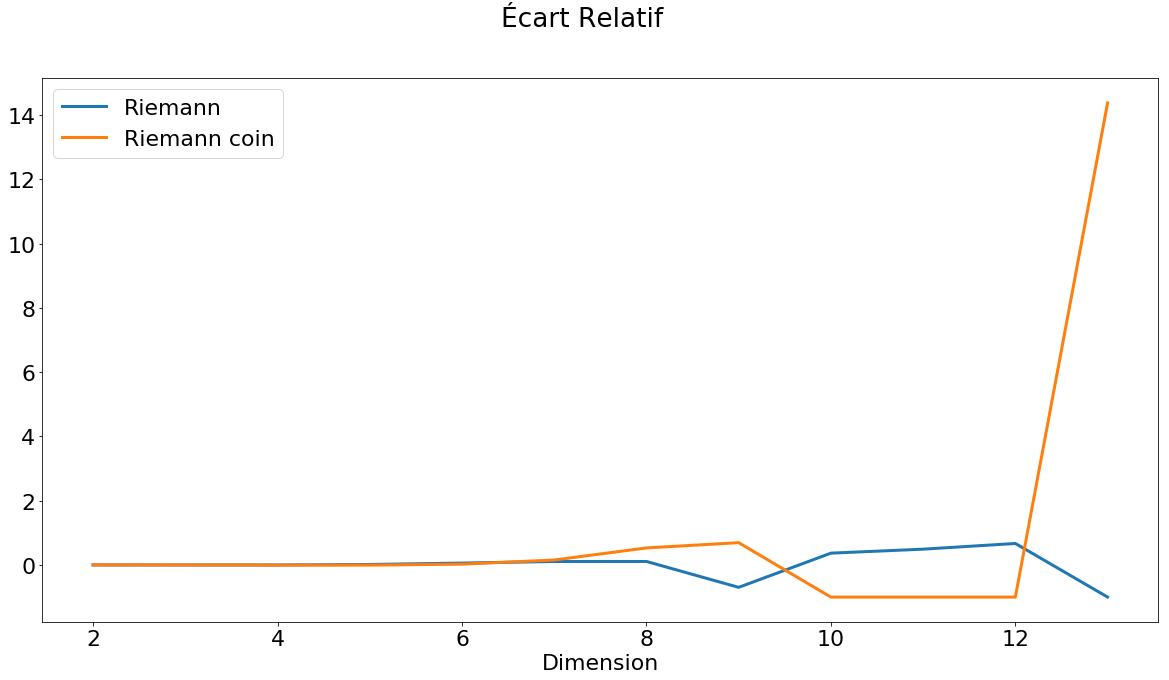

In [12]:
# Calculs des valeurs
est_Riemann = np.zeros([nb_dimensions,2])
est_Riemann_coin = np.zeros([nb_dimensions,2])
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par la méthode de Riemann en dimension",dim)
    grille = grille_Riemann(dim, N);
    est_Riemann[i,:] = estimation_Riemann(dim, grille)
    est_Riemann_coin[i,:] = estimation_Riemann_coin(dim, grille)

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Volume Hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Écart Relatif")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.3.</b> La mèthode de Riemann donne un résultat  sensibles au niveau de dimension. Donc, travailler avec cette methode à haute dimentions pose de problème lié au mauvaise comportement du calcul du volume.  </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION I.4.</b> Soit $V^-_d$ le volume de la sphère de rayon $1 - K/d$ en dimension $d$ : montrez théoriquement que $V_d - V^-_d \sim (1-e^{-K}) V_d$ lorsque $d \to \infty$, et utilisez ce résultat pour interpréter les résultats précédents.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.4.</b> </div>


<p class="bg-primary" style="padding:1em"> <b>$\star$ QUESTION I.5 $\star$.</b> Quel bilan tirez-vous de l'estimation d'intégrales par somme de Riemann? </p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.5.</b> </div>

<a id="MC"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">II. Introduction à la méthode de Monte-Carlo : le cas IID</h1>

<div class="alert alert-success">On introduit maintenant la méthode de Monte-Carlo sur le même problème d'estimation du volume de la sphère et on discute sa vitesse de convergence.<br>
<b>Rappel</b> i.i.d. = indépendantes et identiquement distribuées</div>

<h2>II.1. Méthode de Monte-Carlo</h2>

Soit $(X_k, k \geq 1)$ des variables i.i.d. uniformément réparties sur $[-1,1]^d$ et
$$ \widehat V^{\text{MC}}_d = \frac{2^d}{N} \sum_{k=1}^N f(X_k). $$

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.1.</b> Donnez la densité de $X_1$ et justifiez que $\widehat V^{\text{MC}}_d \to V_d$ lorsque $N \to \infty$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.1.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.2.</b> Complétez la fonction <code>estimation_IIDMC</code> afin d'ajouter aux courbes précédentes l'évolution de $\widehat V^{\text{MC}}_d$ ainsi que l'écart relatif correspondant. Commentez les courbes obtenues.</p>

In [61]:
def estimation_IIDMC(dim, taille_echantillon):
    """
    Calcule l'approximation du volume de la sphére en dimension
    dim à l'aide de la méthode de Monte-Carlo
    """
    N = taille_echantillon
    Xk = np.random.uniform(low = -1, high = 1, size = (N,dim))
    #print(Xk)
    estimation = 2**dim/N*sum(np.linalg.norm(Xk,axis = 1)<=1)
    #print(estimation)
    V = np.pi**(dim/2)/special.gamma(dim/2+1)
    #print(V)
    ecart_relatif = (estimation-V)/V
    erreur_relative = np.sqrt((2**dim/V - 1)/N) # A COMPLETER A LA QUESTION II.2.6
    #print(erreur_relative)
    return [estimation, ecart_relatif, erreur_relative]

In [14]:
a = np.array([1,2,3])
a[0:2]


array([1, 2])

Estimation par Monte Carlo en dimension: 2
Estimation par Monte Carlo en dimension: 3
Estimation par Monte Carlo en dimension: 4
Estimation par Monte Carlo en dimension: 5
Estimation par Monte Carlo en dimension: 6
Estimation par Monte Carlo en dimension: 7
Estimation par Monte Carlo en dimension: 8
Estimation par Monte Carlo en dimension: 9
Estimation par Monte Carlo en dimension: 10
Estimation par Monte Carlo en dimension: 11
Estimation par Monte Carlo en dimension: 12
Estimation par Monte Carlo en dimension: 13


Text(0.5,0,'Dimension')

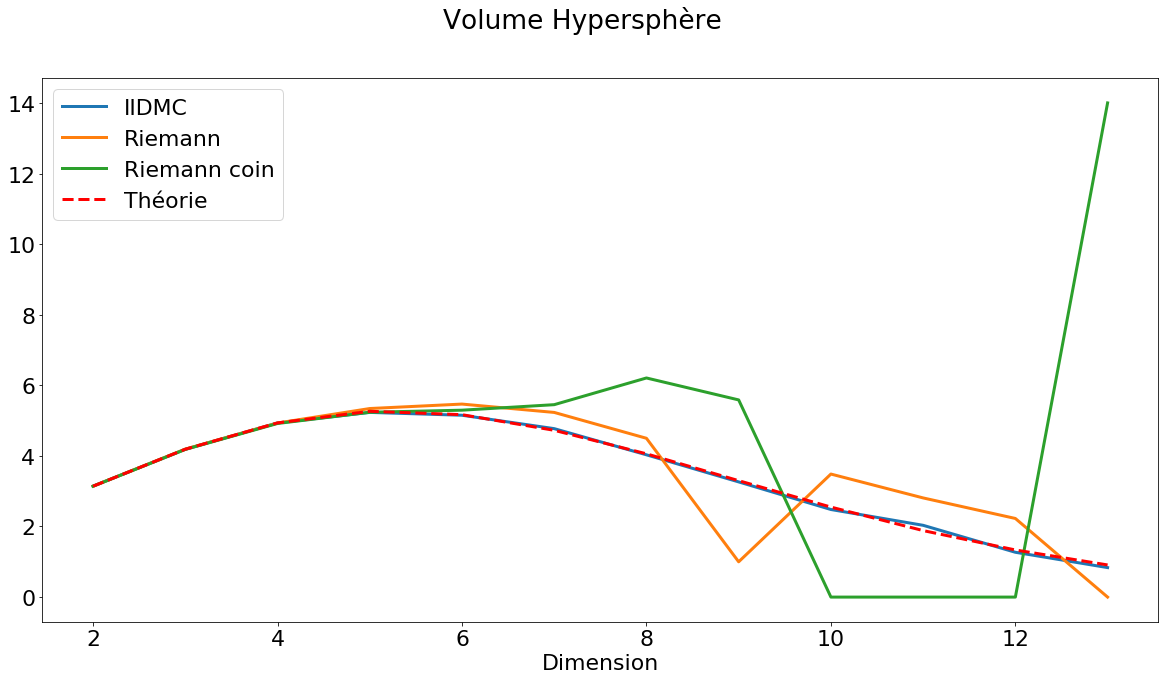

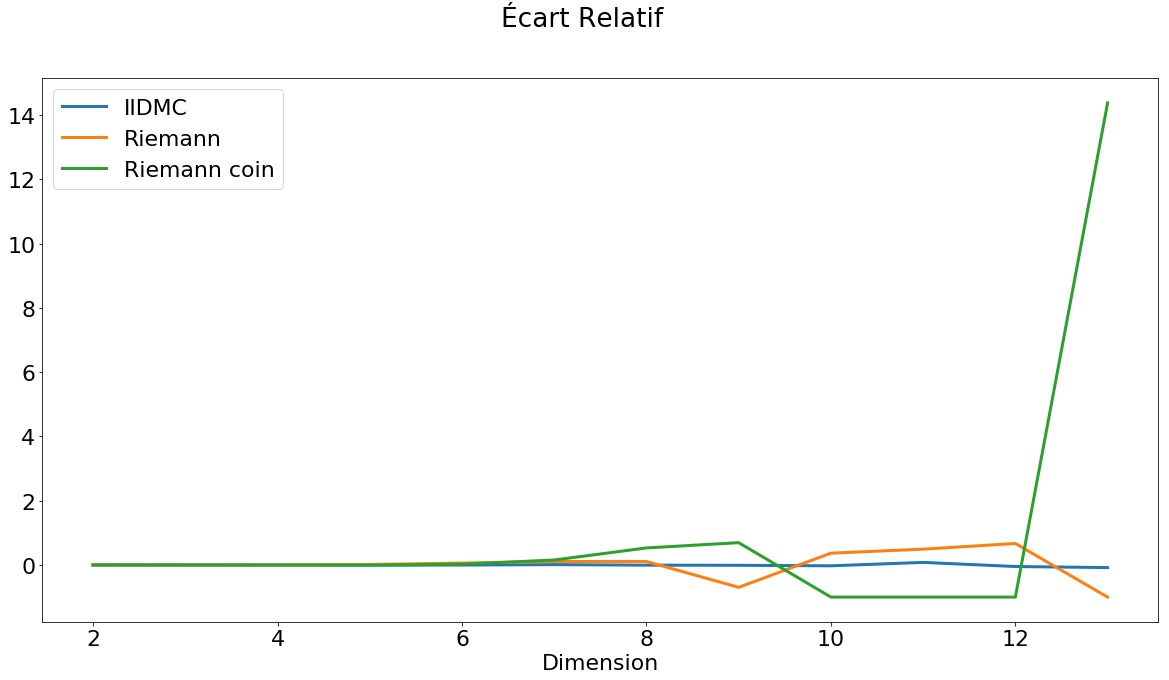

In [15]:
N = 10**6 
# Calculs des valeurs
est_IIDMC = np.zeros([nb_dimensions,2])
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par Monte Carlo en dimension:",dim)
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N)[0:2]

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
th, = plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Volume Hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Écart Relatif")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.2.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.3.</b> Faites tourner le script suivant et commentez les résultats obtenus.</p>

Text(0.5,0,'Dimension')

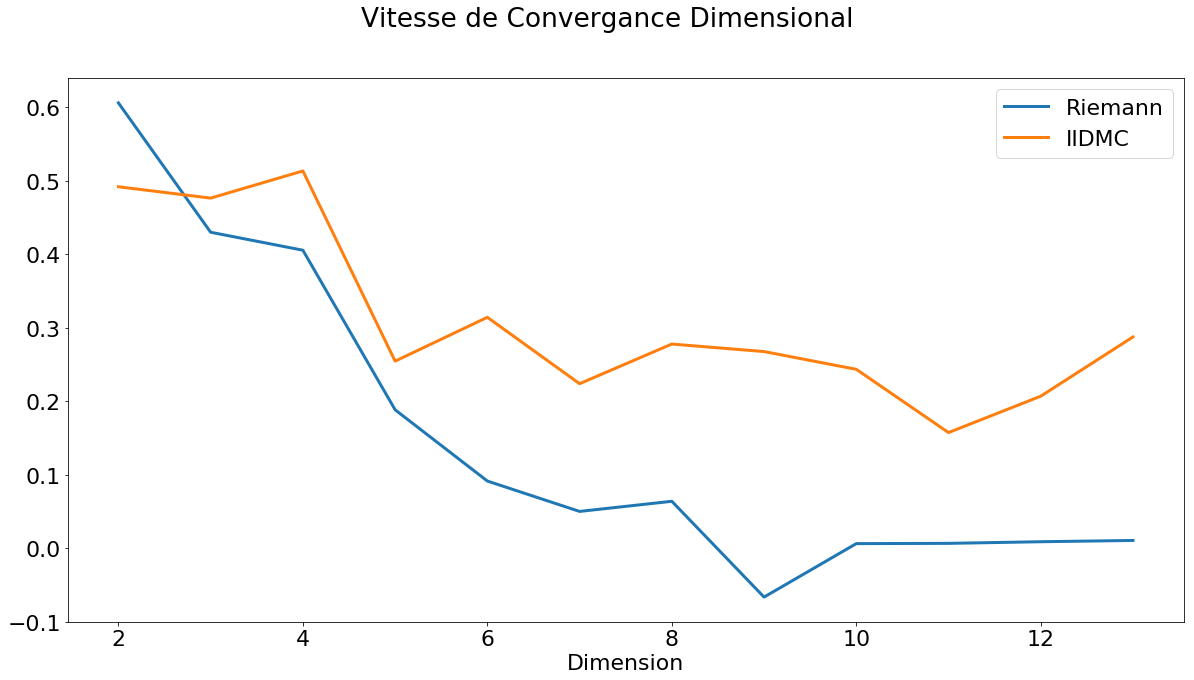

In [16]:
vitesse_IIDMC = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_IIDMC[i] = -np.log(np.absolute(est_IIDMC[i,0] - val_th[i])) / np.log(N_effectif(dim, N))
fig = plt.figure()
plt.plot(dimensions, vitesse_R, label="Riemann")
plt.plot(dimensions, vitesse_IIDMC, label="IIDMC")
plt.legend()
fig.suptitle("Vitesse de Convergance Dimensional")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.3.</b> La methode de Monte Carlo atteindre la convergance plus rapidement avec la dimension du problèeme. Contrirement à la methode de Riemann, les résultats converge à haute dimension.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.4.</b> Quelle est la vitesse de convergence théorique de l'estimateur $\widehat V^{MC}_d$? Cette vitesse dépend-elle de la dimension ? Commentez par rapport aux résultats numériques précédents.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.4.</b> 1/sqrt(N)</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.5.</b> On fixe la dimension $d = 15$. Répétez l'expérience plusieurs fois : l'estimation donnée par $\widehat V^{\text{MC}}_d$ est-elle stable ? Et la vitesse de convergence ? Commentez les résultats obtenus et notamment l'influence de $N$.</p>

In [34]:
nb_repet = 10**1
dim = 15
estim = np.zeros(nb_repet)
vitesse = np.zeros(nb_repet)
val_th = np.zeros(nb_repet) + np.pi**(dim/2) / special.gamma(dim/2+1)
for i in range(nb_repet):
    estim[i] = estimation_IIDMC(dim, N)[0]
    vitesse[i] = -np.log(np.absolute(estim[i] - val_th[i])) / np.log(N)

Text(0.5,0.98,'Étude de Convergance')

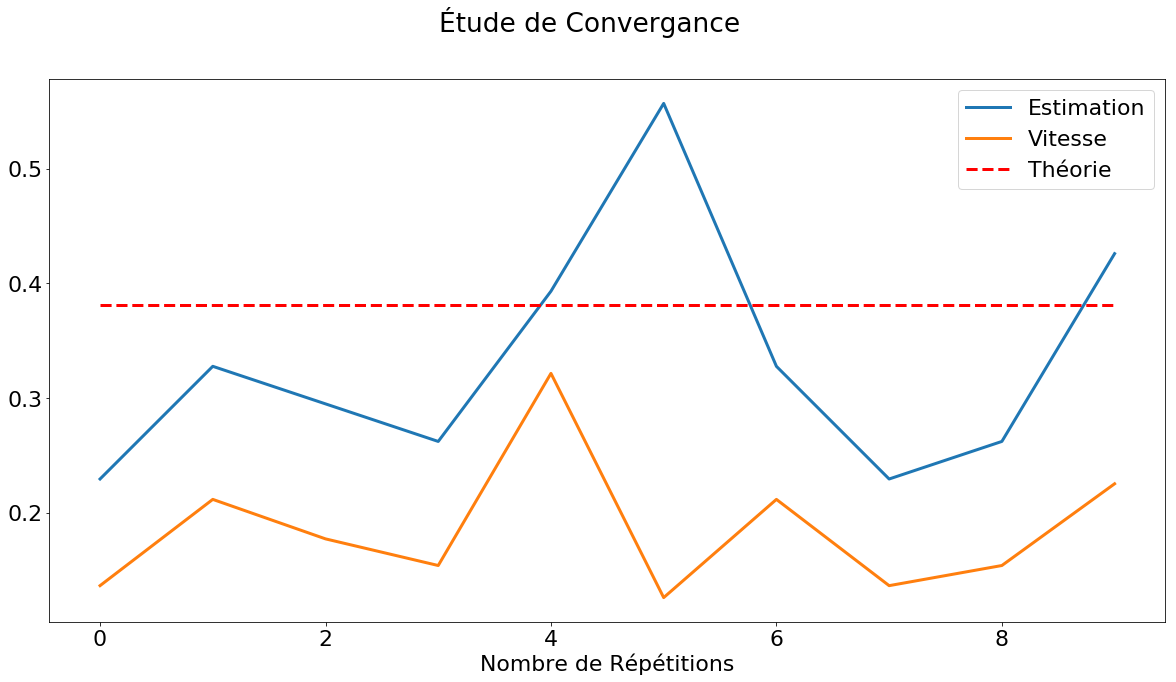

In [35]:
plt.plot(range(nb_repet), estim, label = "Estimation")
plt.plot(range(nb_repet), vitesse, label = "Vitesse")
plt.plot(range(nb_repet), val_th, 'r--', label = "Théorie")
plt.xlabel("Nombre de Répétitions")
plt.legend()
plt.suptitle("Étude de Convergance")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.5.</b> L'estimation et la vitesse sont stables et oscillant autour de la respective moyenne.</div>

<h2>II.2. Précision d'un estimateur</h2>

Le but de cette partie est de montrer que la variance n'est toujours pas une mesure satisfaisante pour mesurer la précision d'un estimateur. On considère pour cela la fonction $p(t) = P(\lVert X \rVert \leq t)$ où $X$ est uniformément répartie sur $[-1,1]^d$.

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.1</b> Donnez l'estimateur de Monte-Carlo de $p(t)$, que l'on notera $\widehat p(t)$, ainsi que son espérance et sa variance. En déduire que $\frac{1}{N} (\widehat p(t) - \widehat p(t)^2)$ est un estimateur de la variance de $\widehat p(t)$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.1.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.2.</b> Complétez le script suivant afin de tracer $t \mapsto \widehat p(t) - \widehat p(t)^2$. Pour quelle valeur de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

Text(0.5,0.98,'Influence de la Taille de la Hypersphère')

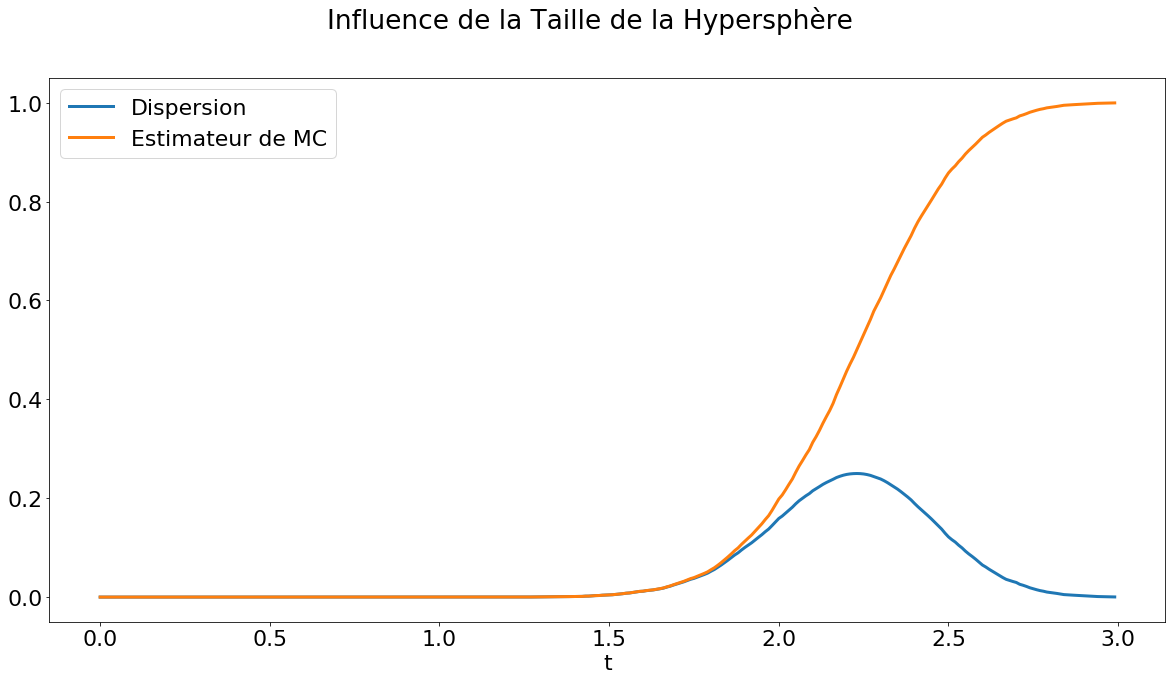

In [47]:
taille_echantillon = 10**4
dim = 15
echantillon = np.random.uniform(low = -1, high = 1, size = (taille_echantillon,dim))
valeurs_t = np.arange(0,3,.01)
estimation_p = np.zeros((len(valeurs_t),1))
for i in range(len(valeurs_t)):
    estimation_p[i] = 1/taille_echantillon*sum(np.linalg.norm(echantillon,axis = 1)<=valeurs_t[i])
plt.xlabel("t")
plt.plot(valeurs_t, estimation_p - np.power(estimation_p,2), label="Dispersion")
plt.plot(valeurs_t, estimation_p, label= "Estimateur de MC")

plt.legend()
plt.xlabel("t")
plt.suptitle("Influence de la Taille de la Hypersphère")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.2.</b>Pour t = 2.25 l'estimateur se resemble le moins precis, car la variance est maximale. </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.3.</b> Justifiez le choix de
$$ \frac{\sqrt{\widehat p(t) - \widehat p(t)^2}}{\widehat p(t)} $$
pour évaluer la précision de $\widehat p(t)$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.3.</b> Néanmoins, le valeur de la dispersion est petit pour valeurs de t petit, si nous comparons avec le valeur de p, la dispersion est significative. Donc, c'est bien de normaliser la dispersion. </div>

<div class="alert alert-success center;">On définit l'<b>erreur relative</b> comme le rapport entre l'écart-type de l'estimateur et sa moyenne :
$$ \text{erreur relative} = \frac{\sqrt{\text{Var}(\widehat V)}}{E (\widehat V)} $$
En pratique, ces valeurs sont inconnues mais on peut les estimer par Monte-Carlo.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.4.</b> Reprenez et complétez le script précédent afin de tracer, sur une autre figure, la courbe $t \mapsto \sqrt{1/\widehat p(t) - 1}$. Pour quelles valeurs de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5,0.98,"Erreur Relativ de l'Estimateur")

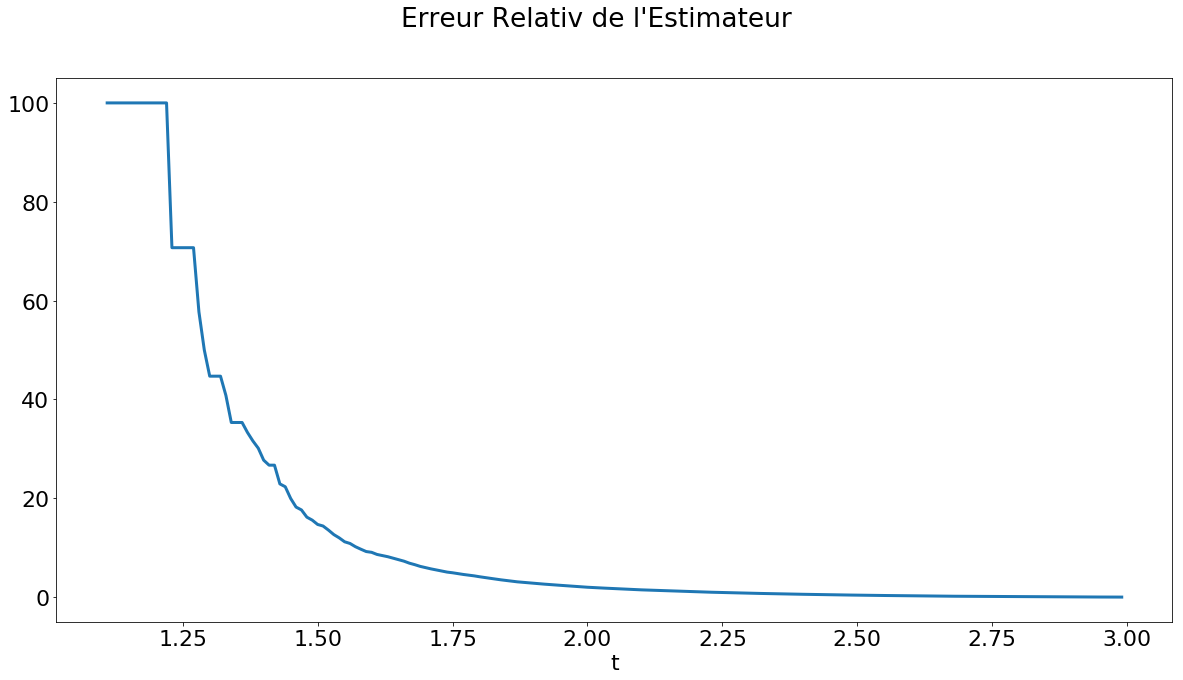

In [50]:
plt.xlabel("t")
plt.plot(valeurs_t, np.sqrt(1/estimation_p - 1), label="Dispersion normalisée")
plt.suptitle("Erreur Relativ de l'Estimateur")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.4.</b>Pour les valeurs de rayon t faible. </div>

On revient maintenant au cas de la sphère.

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION II.2.5. $\star$</b> Montrez que dans ce cas, l'erreur relative de l'estimateur de Monte-Carlo est donnée par
$$ \frac{\sqrt{\text{Var}(\widehat V^{\text{MC}}_d)}}{E(\widehat V^{\text{MC}}_d)} = \frac{c_d}{\sqrt N} \ \text{ avec } \ c_d = \sqrt{\frac{2^d}{V_d}-1}. $$</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.5.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.6.</b> Modifiez la fonction <code>estimation_IIDMC</code> de telle sorte à ce qu'elle calcule également l'erreur relative d'estimation du volume de la sphère. Tracez la courbe correspondante et commentez les résultats obtenus.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.6.</b> </div>

Estimation par Monte Carlo en dimension: 2
Estimation par Monte Carlo en dimension: 3
Estimation par Monte Carlo en dimension: 4
Estimation par Monte Carlo en dimension: 5
Estimation par Monte Carlo en dimension: 6
Estimation par Monte Carlo en dimension: 7
Estimation par Monte Carlo en dimension: 8
Estimation par Monte Carlo en dimension: 9
Estimation par Monte Carlo en dimension: 10
Estimation par Monte Carlo en dimension: 11
Estimation par Monte Carlo en dimension: 12
Estimation par Monte Carlo en dimension: 13


Text(0.5,0,'Dimension')

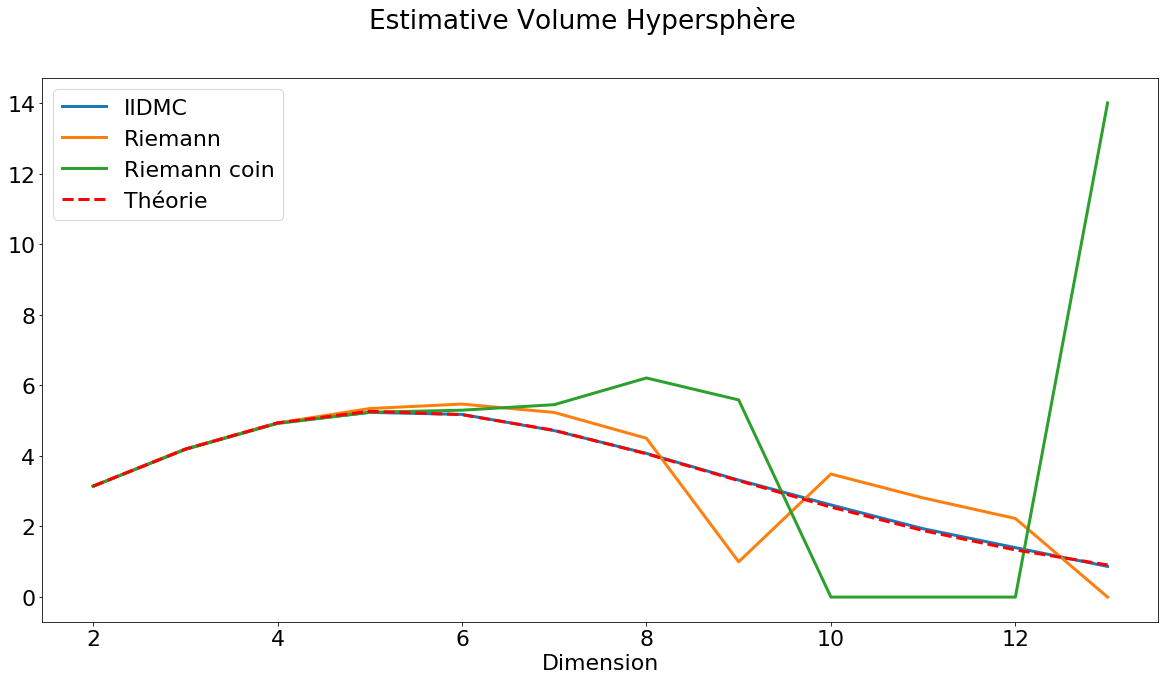

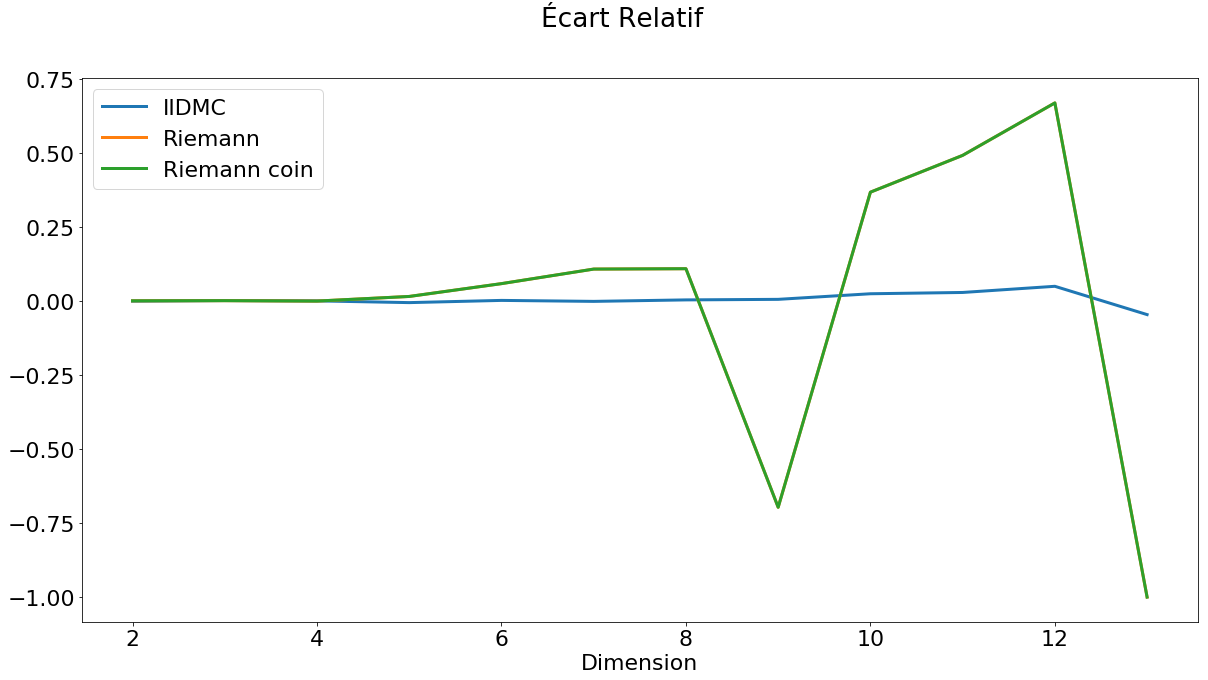

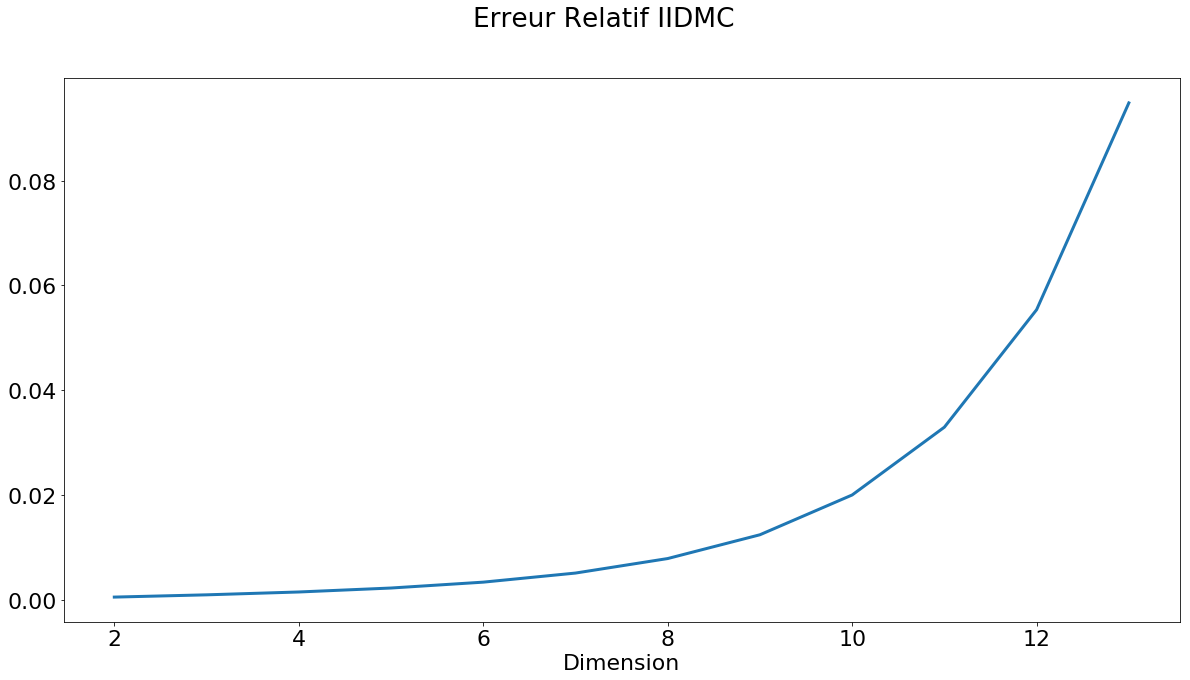

In [63]:
# Calculs des valeurs
est_IIDMC = np.zeros([nb_dimensions,3])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    val_th[i] = np.pi**(dim/2) / special.gamma(dim/2+1) 
    print("Estimation par Monte Carlo en dimension:",dim)
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N)[0:3]

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Estimative Volume Hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Écart Relatif")
plt.xlabel("Dimension")

fig = plt.figure()
errel_IIDMC, = plt.plot(dimensions, est_IIDMC[:,2])
fig.suptitle("Erreur Relatif IIDMC")
plt.xlabel("Dimension")

<h2>II.3. Limitations de la méthode IIDMC</h2>

On conclut cette partie par une limitation évidente de la méthode de Monte-Carlo.

<p class="bg-primary" style="padding:1em"><b>QUESTION II.3.1.</b> Que vaut $\widehat V^{\text{MC}}_{30}$ pour $N = 10^6$? Faites un calcul d'ordre de grandeur pour déterminer le nombre d'échantillons qu'il faudrait pour avoir une erreur relative $\leq 10^{-2}$.</p>

In [75]:
N = 10**6
dim = 30
Vd = np.pi**(dim/2)/special.gamma(dim/2+1)
print(Vd)
N2 = (np.sqrt(2**dim/Vd-1)/0.02)**2
print(N2)
print(estimation_IIDMC(dim, N))

2.19153534478e-05
1.22487395259e+17
[0.0, -1.0, 6999.6398552715928]


<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.3.1.</b> Ordre de grandeur de 17. </div>

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION II.3.2. $\star$</b> Quel bilan tirez-vous de l'estimation d'intégrales par méthode de Monte-Carlo? </p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.3.2.</b> Pour dimension petit, inferieur à 10 par example, lq methode de Monte Carlo approxime efficacement le valeur cible. Par contre, quand la dimension du probleme augmente, L'erreur tend vers infinie, donc la enchentillonage faudrait atteindre l'infinie. Cela pose de probleme computationelle.</div>

<div class="alert alert-danger"><b>On a illustré ci-dessus la méthode de Monte-Carlo sur l'exemple du calcul de l'intégrale
$$ \int_{[-1,1]^d} \phi(x) d x \ {\bf {\text{ avec }}} \ \phi(x) = {\bf 1}(\lVert x \rVert \leq 1). $$
L'idée a été d'interpréter l'intégrale comme une espérance et d'utiliser la loi forte des grands nombres pour approcher cette espérance. Cette idée se généralise aisément au calcul de l'intégrale
$$ \int \phi(x) f(x) d x $$
où $f$ est une densité, en réécrivant cette intégrale comme l'espérance de la variable aléatoire $\phi(X)$ où $X$ est de densité $f$. Par ailleurs, contrairement au cas déterministe, la vitesse de convergence de cette méthode est indépendante de la dimension du problème!</b></div>

